In [1]:
import anndata as ad
import networkx as nx
import scanpy as sc
import scglue
from matplotlib import rcParams
import numpy as np
import scripro
import pandas as pd
import warnings
import seaborn as sns
from itertools import chain
from scipy.spatial.distance import cdist
warnings.filterwarnings("ignore")

## Load data

Respectively loaded ATAC-seq and RNA-seq data.

In [2]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [3]:
rna = sc.read_h5ad("/fs/home/xuyunfan/data/10x/lymph2/rna/rna.h5ad")

In [4]:
rna.var_names_make_unique()

In [5]:
rna.raw = rna

In [6]:
atac = sc.read_h5ad('/fs/home/xuyunfan/data/10x/lymph2/atac/atac.h5ad')

## Use GLUE to compute scATAC-matched scRNA barcodes

Here, we use GLUE to align the two omics data,here is the normal GLUE workflow:

In [7]:
atac.var_names_make_unique()

In [8]:
rna.layers["counts"] = rna.X.copy()

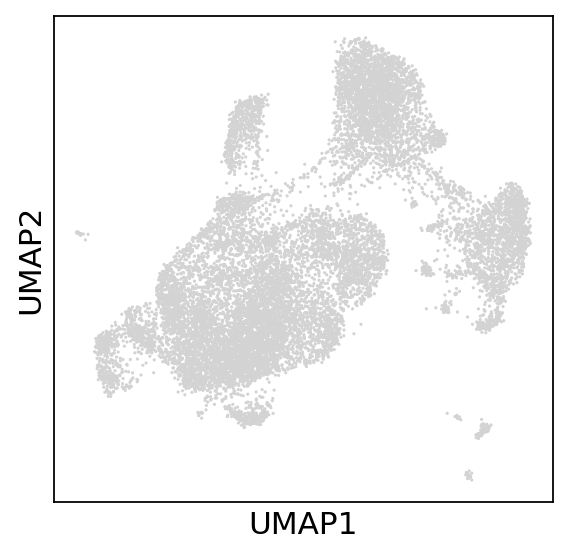

In [9]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.pl.umap(rna)

In [10]:
scglue.data.lsi(atac, n_components=5, n_iter=15)

In [11]:
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)

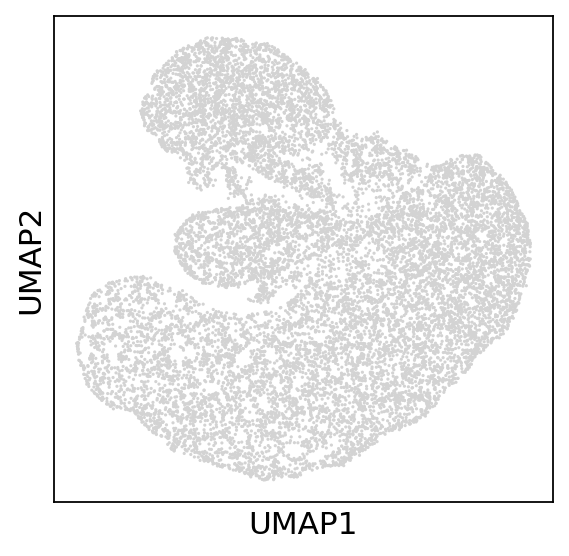

In [12]:
sc.pl.umap(atac)

In [13]:
scglue.data.get_gene_annotation(
    rna, gtf="../data/gencode.v43.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)

In [14]:
rna.var.index.is_unique

True

In [15]:
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]]

,chrom,chromStart,chromEnd
MIR1302-2HG,chr1,29553.0,31109.0
FAM138A,chr1,34553.0,36081.0
OR4F5,chr1,65418.0,71585.0
AL627309.1,NaN,NaN,NaN
AL627309.3,NaN,NaN,NaN
...,...,...,...
AC141272.1,NaN,NaN,NaN
AC023491.2,NaN,NaN,NaN
AC007325.1,NaN,NaN,NaN
AC007325.4,NaN,NaN,NaN


In [16]:
genes_to_remove = rna.var[~(rna.var.loc[:,"chromStart"]>0)].index

In [17]:
rna = rna[:, ~rna.var.index.isin(genes_to_remove)]

In [18]:
atac.var_names[:5]

Index(['chr1_9795_10696', 'chr1_17061_17939', 'chr1_180997_181703',
       'chr1_183968_184757', 'chr1_186502_187406'],
      dtype='object')

In [19]:
split = atac.var_names.str.split(r"[_]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
atac.var.head()

,chrom,chromStart,chromEnd
chr1_9795_10696,chr1,9795,10696
chr1_17061_17939,chr1,17061,17939
chr1_180997_181703,chr1,180997,181703
chr1_183968_184757,chr1,183968,184757
chr1_186502_187406,chr1,186502,187406


In [20]:
rna.var

,highly_variable,means,dispersions,dispersions_norm,mean,std,chrom,chromStart,chromEnd,name,...,itemRgb,blockCount,blockSizes,blockStarts,gene_id,gene_type,tag,hgnc_id,havana_gene,artif_dupl
MIR1302-2HG,False,1.000000e-12,NaN,0.000000,0.000000,1.000000,chr1,29553.0,31109.0,MIR1302-2HG,...,.,.,.,.,ENSG00000243485.5,lncRNA,ncRNA_host,HGNC:52482,OTTHUMG00000000959.2,NaN
FAM138A,False,1.000000e-12,NaN,0.000000,0.000000,1.000000,chr1,34553.0,36081.0,FAM138A,...,.,.,.,.,ENSG00000237613.2,lncRNA,NaN,HGNC:32334,OTTHUMG00000000960.1,NaN
OR4F5,False,5.497313e-03,1.040101,-1.097506,0.002889,0.056353,chr1,65418.0,71585.0,OR4F5,...,.,.,.,.,ENSG00000186092.7,protein_coding,NaN,HGNC:14825,OTTHUMG00000001094.4,NaN
OR4F29,False,1.000000e-12,NaN,0.000000,0.000000,1.000000,chr1,450739.0,451678.0,OR4F29,...,.,.,.,.,ENSG00000284733.2,protein_coding,NaN,HGNC:31275,OTTHUMG00000002860.3,NaN
OR4F16,False,1.000000e-12,NaN,0.000000,0.000000,1.000000,chr1,685715.0,686654.0,OR4F16,...,.,.,.,.,ENSG00000284662.2,protein_coding,NaN,HGNC:15079,OTTHUMG00000002581.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4,True,2.037123e+00,4.331923,3.915107,0.950185,1.276617,chrM,10759.0,12137.0,MT-ND4,...,.,.,.,.,ENSG00000198886.2,protein_coding,NaN,HGNC:7459,NaN,NaN
MT-ND5,True,6.776105e-01,3.704260,5.513758,0.219016,0.636512,chrM,12336.0,14148.0,MT-ND5,...,.,.,.,.,ENSG00000198786.2,protein_coding,NaN,HGNC:7461,NaN,NaN
MT-ND6,True,2.098734e-01,3.157219,1.393144,0.062790,0.337936,chrM,14148.0,14673.0,MT-ND6,...,.,.,.,.,ENSG00000198695.2,protein_coding,NaN,HGNC:7462,NaN,NaN
MT-CYB,True,1.438881e+00,4.125400,4.742718,0.554779,1.015753,chrM,14746.0,15887.0,MT-CYB,...,.,.,.,.,ENSG00000198727.2,protein_coding,NaN,HGNC:7427,NaN,NaN


In [21]:
guidance = scglue.genomics.rna_anchored_guidance_graph(rna, atac)
guidance

window_graph:   0%|          | 0/23469 [00:00<?, ?it/s]

In [22]:
scglue.graph.check_graph(guidance, [rna, atac])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [23]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca"
)

In [24]:
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [25]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

In [26]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance_hvf,
    fit_kws={"directory": "glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 24764
[INFO] SCGLUEModel: Setting `max_epochs` = 118
[INFO] SCGLUEModel: Setting `patience` = 10
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 5
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.447, 'g_kl': 0.008, 'g_elbo': 0.455, 'x_rna_nll': 0.217, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.221, 'x_atac_nll': 0.238, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.239, 'dsc_loss': 0.688, 'vae_loss': 0.478, 'gen_loss': 0.444}, val={'g_nll': 0.446, 'g_kl': 0.008, 'g_elbo': 0.454, 'x_rna_nll': 0.21, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.214, 'x_atac_nll': 0.243, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.244, 'dsc_loss': 0.691, 'vae_loss': 0.476, 'gen_loss': 0

2023-12-22 16:55:32,773 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "34"...
[INFO] EarlyStopping: Restoring checkpoint "34"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (18, 32)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 24764
[INFO] SCGLUEModel: Setting `align_burnin` = 20
[INFO] SCGLUEModel: Setting `max_epochs` = 118
[INFO] SCGLUEModel: Setting `patience` = 10
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 5
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.428, 'g_kl': 0.007, 'g_elbo': 0.435, 'x_rna_nll': 0.215, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.219, 'x_atac_nll': 0.238, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.239, 'dsc_loss': 0.688, 'vae_loss': 0.475, 'gen_loss': 0.441}, val={'g_nll': 0.428, 'g_kl': 0.007, 'g_elbo': 0.435, 'x_rna_nll': 0.215, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.218, 'x_atac_nll': 0.225, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.225, 'dsc_loss': 0.699, 'vae_loss': 0.461, 'gen_loss': 0.426

2023-12-22 17:04:12,662 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "45"...
[INFO] EarlyStopping: Restoring checkpoint "45"...


In [27]:
dx = scglue.models.integration_consistency(
    glue, {"rna": rna, "atac": atac}, guidance_hvf
)

[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 47 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 88 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 139 common metacells...


In [28]:
dx

,n_meta,consistency
0,10,0.320081
1,20,0.281343
2,50,0.216881
3,100,0.169161
4,200,0.136142


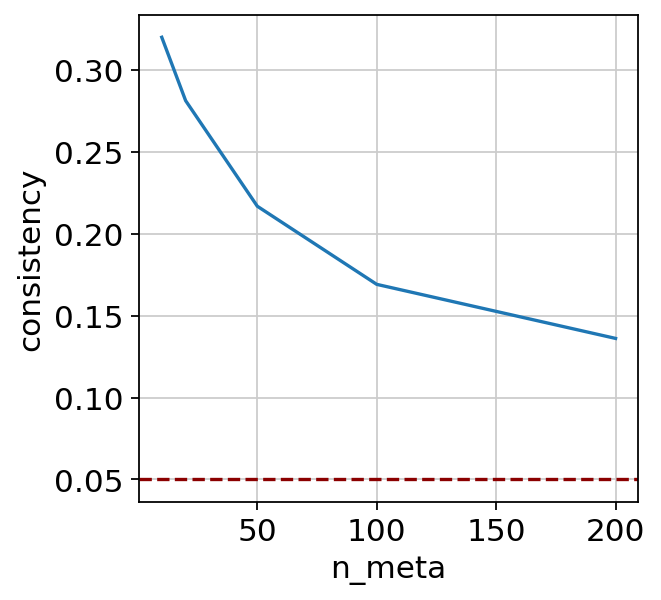

In [29]:
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")

In [30]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [31]:
rna

AnnData object with n_obs × n_vars = 14566 × 23469
    obs: 'balancing_weight'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'tag', 'hgnc_id', 'havana_gene', 'artif_dupl'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', '__scglue__'
    obsm: 'X_pca', 'X_umap', 'X_glue'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [32]:
atac

AnnData object with n_obs × n_vars = 14566 × 109789
    obs: 'balancing_weight'
    var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
    uns: 'neighbors', 'umap', '__scglue__'
    obsm: 'X_lsi', 'X_umap', 'X_glue'
    obsp: 'distances', 'connectivities'

In [33]:
rna.obs['feature']='rna'

In [34]:
atac.obs['feature']='atac'

In [35]:
combined = ad.concat([rna, atac])

In [36]:
combined

AnnData object with n_obs × n_vars = 29132 × 0
    obs: 'balancing_weight', 'feature'
    obsm: 'X_umap', 'X_glue'

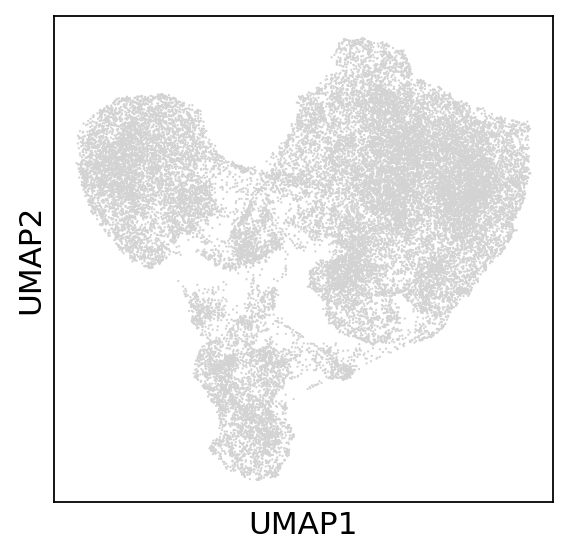

In [37]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)
sc.pl.umap(combined)

In [38]:
sc.tl.leiden(combined,resolution=0.8)

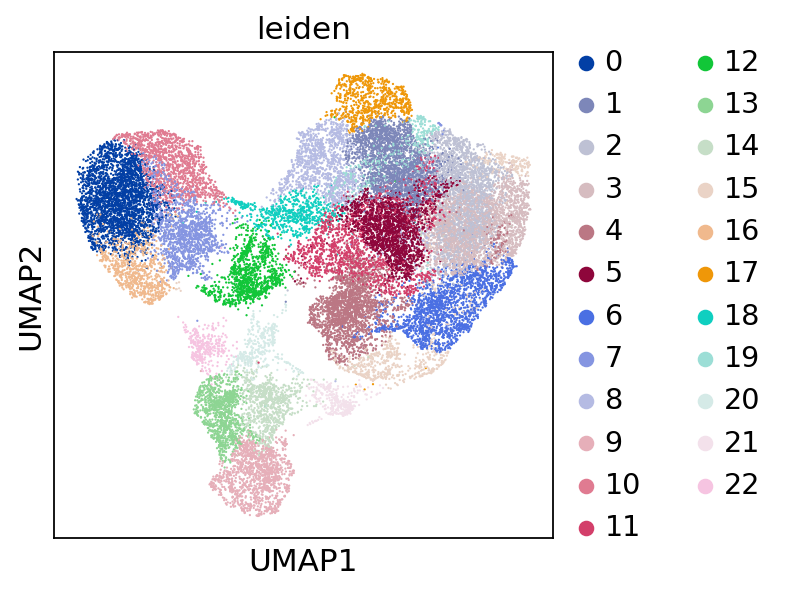

In [39]:
sc.pl.umap(combined,color='leiden')

In [40]:
combined

AnnData object with n_obs × n_vars = 29132 × 0
    obs: 'balancing_weight', 'feature', 'leiden'
    uns: 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_umap', 'X_glue'
    obsp: 'distances', 'connectivities'

In [41]:
combined_rna = combined[combined.obs.feature == 'rna']

In [42]:
combined_rna

View of AnnData object with n_obs × n_vars = 14566 × 0
    obs: 'balancing_weight', 'feature', 'leiden'
    uns: 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_umap', 'X_glue'
    obsp: 'distances', 'connectivities'

In [43]:
combined_rna.obs

,balancing_weight,feature,leiden
AAACAGCCAGAACCGA-1,0.766128,rna,0
AAACAGCCAGCCTAAC-1,3.160764,rna,1
AAACAGCCATATTGAC-1,1.073027,rna,4
AAACATGCAAATTCGT-1,1.073027,rna,4
AAACATGCAACCTAAT-1,0.660823,rna,9
...,...,...,...
TTTGTTGGTATGGTGC-1,0.432174,rna,12
TTTGTTGGTCAATACG-1,1.097787,rna,3
TTTGTTGGTCAGGAAG-1,0.687277,rna,1
TTTGTTGGTTCAAGAT-1,1.884496,rna,6


In [44]:
combined_rna.obs.loc[:,'new_leiden'] = np.nan

In [45]:
scripro.glue_metacell(combined_rna,50)

In [46]:
rna_leiden_clusters = combined_rna.obs['new_leiden']

In [47]:
rna_leiden_clusters

AAACAGCCAGAACCGA-1     0_1
AAACAGCCAGCCTAAC-1     1_4
AAACAGCCATATTGAC-1     4_0
AAACATGCAAATTCGT-1     4_0
AAACATGCAACCTAAT-1     9_0
                      ... 
TTTGTTGGTATGGTGC-1    12_0
TTTGTTGGTCAATACG-1     3_6
TTTGTTGGTCAGGAAG-1    1_25
TTTGTTGGTTCAAGAT-1     6_0
TTTGTTGGTTTACTTG-1    1_29
Name: new_leiden, Length: 14566, dtype: object

The RNA-Seq and ATAC-seq omics data are combined to generate a new dataset Combined, then divide metacell using the RNA-seq data region, and assign the corresponding metacell to the corresponding ATAC-seq data.

In [48]:
combined_atac = combined[combined.obs.feature == 'atac']

In [49]:
distance_matrix = cdist(combined_atac.obsm['X_umap'], combined_rna.obsm['X_umap'], metric='euclidean')
nearest_rna = np.argmin(distance_matrix, axis=1)

In [50]:
nearest_rna

array([ 1836,  9072,  1954, ..., 13302,  8738, 12567])

In [51]:
atac_leiden_clusters = rna_leiden_clusters[nearest_rna]

In [52]:
atac_leiden_clusters.index = combined_atac.obs.index

In [53]:
rna.obs = combined_rna.obs

In [54]:
cellgroup = pd.DataFrame(atac_leiden_clusters)

In [55]:
cellgroup 

,new_leiden
AAACAGCCAGAACCGA-1,0_4
AAACAGCCAGCCTAAC-1,8_0
AAACAGCCATATTGAC-1,15_0
AAACATGCAAATTCGT-1,4_1
AAACATGCAACCTAAT-1,9_0
...,...
TTTGTTGGTATGGTGC-1,12_0
TTTGTTGGTCAATACG-1,1_17
TTTGTTGGTCAGGAAG-1,18_0
TTTGTTGGTTCAAGAT-1,6_0


## Calculate metacell and markergene

In [56]:
test_data = scripro.Ori_Data(rna,Cell_num=50,use_glue = True)

In [57]:
test_data.get_glue_cluster(rna_leiden_clusters)

In [58]:
test_data.get_positive_marker_gene_parallel()

The data from ATAC-seq is used to generate the corresponding chromatin landscape, that is the bigwig file corresponding to metacell of the same name, which is stored in the folder './bigwig'.

In [59]:
scripro.dataframe_to_sparse_tsv(atac.to_df(), 'test.tsv')

In [60]:
scripro.get_metacell_fragment(cellgroup,'.','./test.tsv',chunksize = 10000000)

7it [01:42, 14.67s/it]

final


In [61]:
scripro.process_tsv('./metacell_fragment/', 'hg38')

Sort tsv files
Merge tsv files
Convert tsv to bigwig format


In [62]:
share_seq_data = scripro.SCRIPro_Multiome(8,'hg38',test_data)

## Calculate the TF activity score

In [63]:
%%time
share_seq_data.cal_ISD_parallel('./bigwig/')

Processing markers: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [45:03<00:00, 16.58s/it]


CPU times: user 1min 30s, sys: 2min 24s, total: 3min 54s
Wall time: 46min 3s


In [ ]:
share_seq_data.get_tf_score()

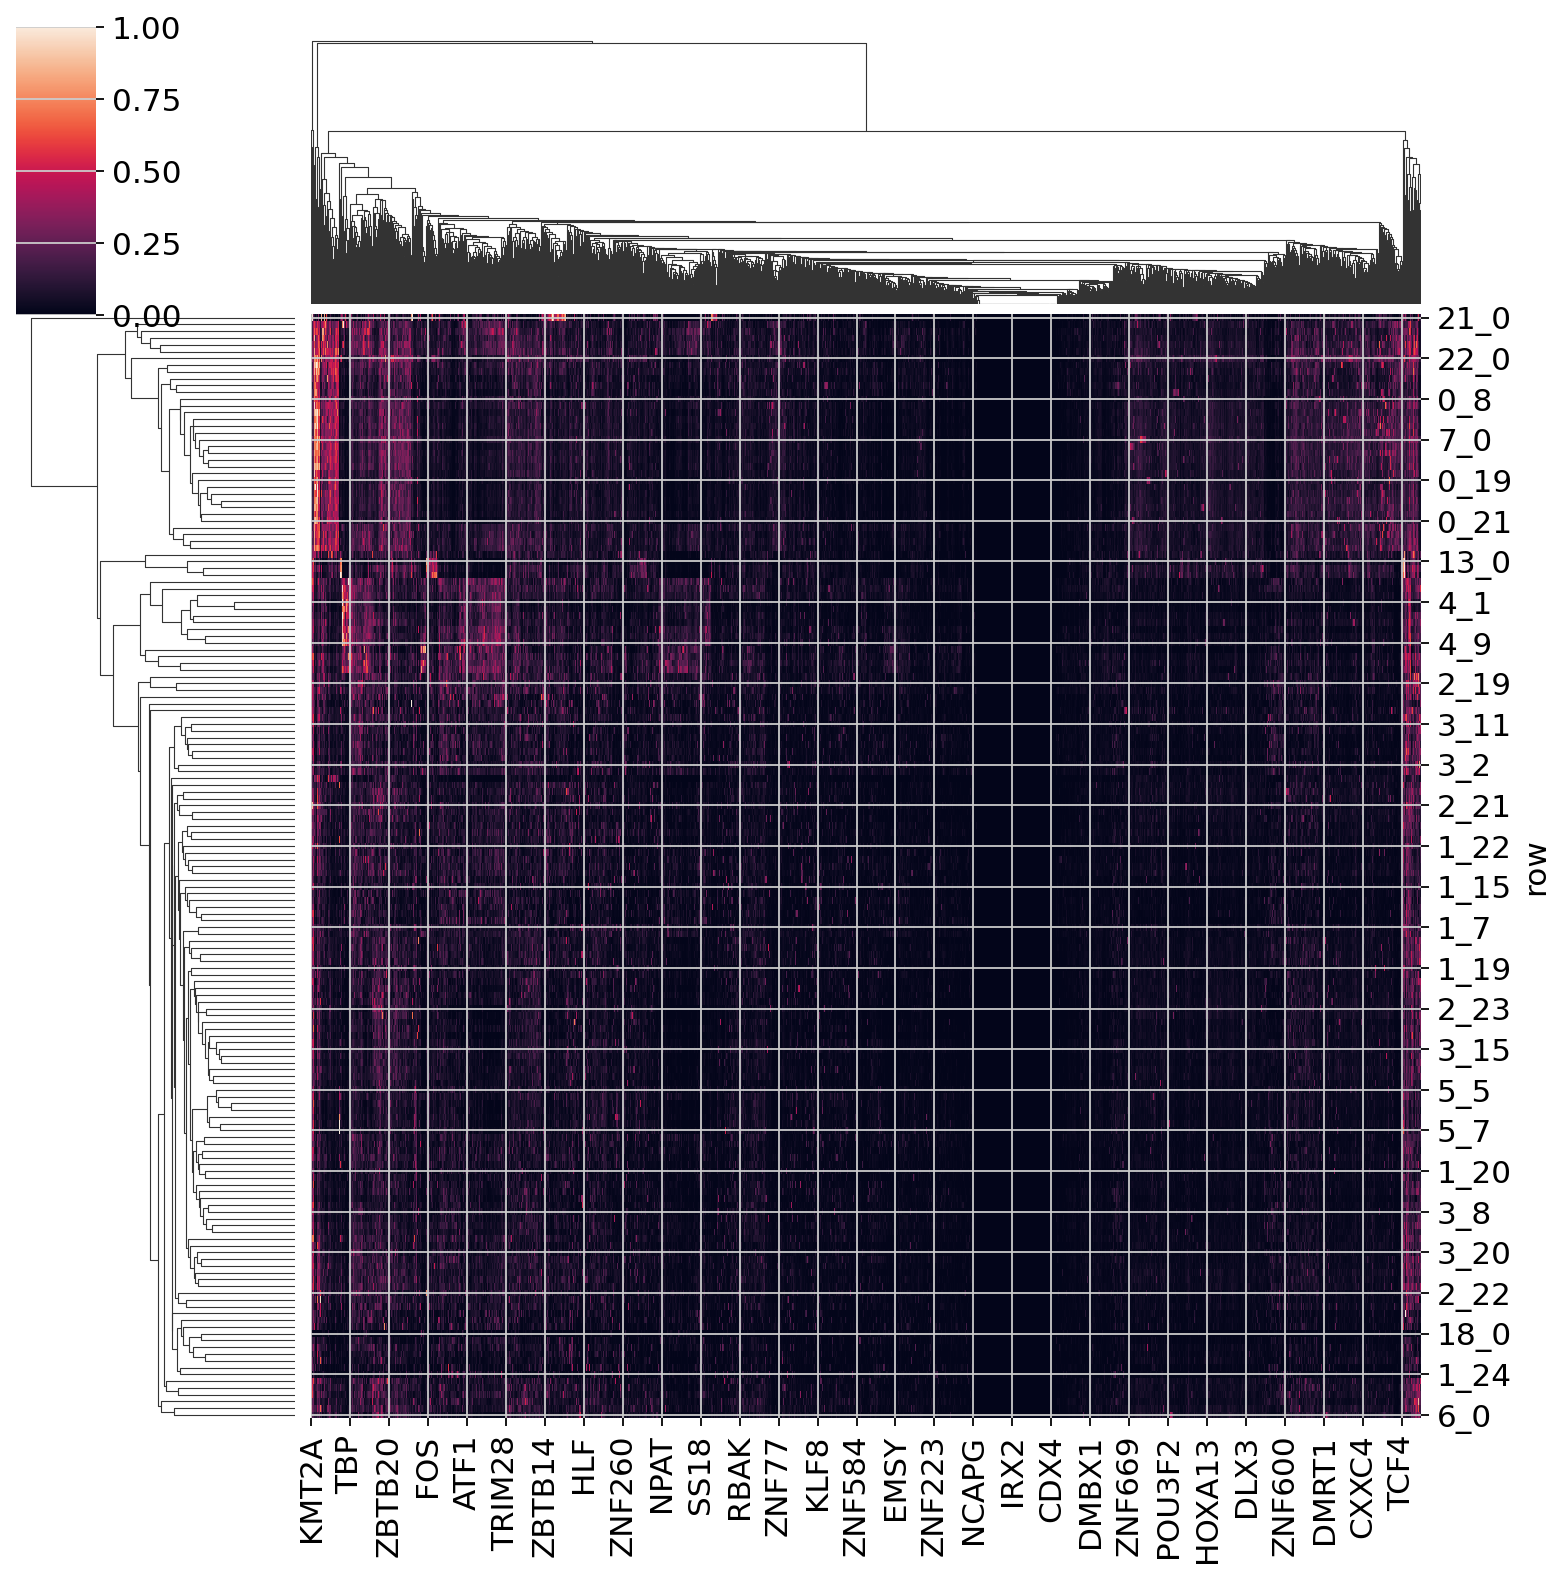

In [69]:
sns.clustermap(share_seq_data.tf_score)